In [1]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
import time

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
from torchvision.utils import make_grid

In [2]:
torch.manual_seed(20210412)
np.random.seed(20210412)

by following the [pytorch CIFAR10 tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

# 1. Data Loading & Manipulation

***The CIFAR-10 dataset***
collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton from the University of Toronto. This dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. Each image is a 3-channel colour images of 32x32 pixels in size. There are 50000 training images and 10000 test images.

### Download the dataset

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load the training data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=len(trainset),#Load entire trainset
                                          shuffle=True, num_workers=2)

# Load the test data
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset), #Load entire testset
                                         shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck') 

Files already downloaded and verified
Files already downloaded and verified


In [4]:
img, label = trainset[0]
img_shape = img.shape
img_shape

torch.Size([3, 32, 32])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 frog


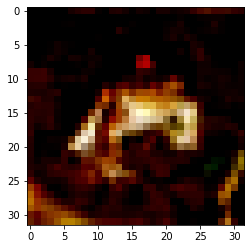

In [5]:
plt.imshow(img.permute((1, 2, 0)))
print(label, classes[label])

### Pre-processing for SVM

In [6]:
# trainset
# convert tensor data(image, label) into numpy array
train_dataset_array, train_dataset_targets =  next(iter(trainloader)) # get a single batch from a trainloader
train_dataset_array = train_dataset_array.numpy()
train_dataset_targets = train_dataset_targets.numpy()

# testset
# convert tensor data(label) into numpy array
test_dataset_array, test_dataset_targets =  next(iter(testloader))
test_dataset_array = test_dataset_array.numpy()
test_dataset_targets = test_dataset_targets.numpy()

In [7]:
# Preprocessing for SVM
d_image, h_image, w_image = train_dataset_array.shape[1:] # (3, 32, 32)->depth(=color) 3*height 32*width 32=3072
X_Train = train_dataset_array.reshape((train_dataset_array.shape[0], d_image*h_image*w_image))

d_image, h_image, w_image = test_dataset_array.shape[1:] # (3, 32, 32)->3*32*32=3072
X_Test = test_dataset_array.reshape((test_dataset_array.shape[0], d_image*h_image*w_image))

# 2. Initial Data Analysis

### Extract a subset with only two classes: Cat(3), Dog(5) for quick overview

In [8]:
cat_dog_train = train_dataset_array[np.where((train_dataset_targets == 3) | (train_dataset_targets == 5))]
cat_dog_train_targets = train_dataset_targets[np.where((train_dataset_targets == 3) | (train_dataset_targets == 5))]

cat_dog_test = test_dataset_array[np.where((test_dataset_targets == 3) | (test_dataset_targets == 5))]
cat_dog_test_targets = test_dataset_targets[np.where((test_dataset_targets == 3) | (test_dataset_targets == 5))]

In [9]:
# Preprocessing for PCA
d_catDog, h_catDog, w_catDog = cat_dog_train.shape[1:] # (3, 32, 32)->depth(=color) 3*height 32*width 32=3072
cat_dog_train_reshape = cat_dog_train.reshape((cat_dog_train.shape[0], d_catDog*h_catDog*w_catDog)) # (10000, 3072)

d_catDog, h_catDog, w_catDog = cat_dog_test.shape[1:] # (3, 32, 32)->3*32*32=3072
cat_dog_test_reshape = cat_dog_test.reshape((cat_dog_test.shape[0], d_catDog*h_catDog*w_catDog)) # (2000, 3072)

In [10]:
# Apply PCA on the training set to reduce the dimensionality.

pca_obs = [] # store 7 values(𝑘1,𝑘2,...,𝑘7) in a list

for i in range(7):
    no_components = 3 *(i+1)*(i+1) # squared values from 1 to 7
    pca_obs.append(PCA(n_components = no_components, svd_solver='randomized', whiten=True).fit(cat_dog_train_reshape))

In [11]:
SVM_training_time = []
SVM_test_time = []
SVM_train_acc = []
SVM_test_acc = []

classifier = SVC(kernel = 'linear', random_state = 0)

for i in range(7): # seven on PCA features with seven different dimension
    pca_obj = pca_obs[i]
    pca_train = pca_obj.transform(cat_dog_train_reshape)
    pca_test = pca_obj.transform(cat_dog_test_reshape)

    t0 = time.time()
    model = classifier.fit(pca_train, cat_dog_train_targets) # SVM
    t1 = time.time() - t0
    SVM_training_time.append(t1)

    # classification accuracy
    SVM_train_acc.append(model.score(pca_train, cat_dog_train_targets))
    SVM_test_acc.append(model.score(pca_test, cat_dog_test_targets))
    
    t0 = time.time()
    pred = model.predict(pca_test)
    t1 = time.time() - t0
    SVM_test_time.append(t1)
    
    scores = cross_val_score(estimator = classifier, X = pca_train, y = cat_dog_train_targets, cv = 10)
    print("Accuracy: {:.2f} %".format(scores.mean()*100))
    print("Standard Deviation: {:.2f} %".format(scores.std()*100))

Accuracy: 57.65 %
Standard Deviation: 1.13 %
Accuracy: 59.10 %
Standard Deviation: 1.72 %
Accuracy: 59.64 %
Standard Deviation: 1.01 %
Accuracy: 59.88 %
Standard Deviation: 1.06 %
Accuracy: 59.90 %
Standard Deviation: 0.93 %
Accuracy: 60.08 %
Standard Deviation: 1.30 %
Accuracy: 60.71 %
Standard Deviation: 1.58 %


In [12]:
SVM_training_time, SVM_test_time, SVM_train_acc, SVM_test_acc

([2.99090838432312,
  6.182642698287964,
  13.614239692687988,
  28.81185293197632,
  41.19778323173523,
  66.76644825935364,
  115.89678692817688],
 [0.13065075874328613,
  0.2738959789276123,
  0.46878600120544434,
  1.0242929458618164,
  1.5583627223968506,
  2.3605008125305176,
  4.576430320739746],
 [0.5779, 0.5945, 0.6029, 0.6077, 0.6131, 0.6187, 0.6299],
 [0.5815, 0.5985, 0.6105, 0.614, 0.6145, 0.6165, 0.6165])

In [13]:
precision_recall_fscore_support(cat_dog_test_targets, pred, average='macro')

(0.6168281703304583, 0.6165, 0.6162304978671274, None)

In [15]:
precision_recall_fscore_support(cat_dog_test_targets, pred, average='micro')

(0.6165, 0.6165, 0.6165, None)

# 3. Define two neural networks
## 3.1 SVM

In [16]:
# Train the network
total_training_time = []
t0 = time.time()

classifier = SVC(kernel = 'linear', random_state = 0)
model = classifier.fit(X_Train, train_dataset_targets)

t1 = time.time() - t0
total_training_time.append(t1)

print('Finished Training')

Finished Training


In [17]:
total_testing_time = []
t0 = time.time()

pred = classifier.predict(X_Test)

t1 = time.time() - t0
total_testing_time.append(t1)

In [18]:
test_accuracies = []
test_accuracies.append(model.score(X_Test, test_dataset_targets))

In [19]:
precision_recall_fscore_support(test_dataset_targets, pred, average='macro')

(0.36552916828646287, 0.3624, 0.36274862415101994, None)

In [20]:
precision_recall_fscore_support(test_dataset_targets, pred, average='micro')

(0.3624, 0.3624, 0.3624, None)

## 3.2 MLP

In [21]:
class MLPNet(nn.Module):
    def __init__(self):
        super(MLPNet, self).__init__()
        self.linear1 = nn.Linear(3 * 32 * 32, 1024)
        self.linear2 = nn.Linear(1024, 512)
        self.linear3 = nn.Linear(512, 64)
        self.linear4 = nn.Linear(64, 64)
        self.linear5 = nn.Linear(64, 10)
        
    def forward(self, x):
        # Flatten images into vectors
        x = x.view(x.size(0), -1)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        x = F.relu(x)
        x = self.linear4(x)
        x = F.relu(x)
        x = self.linear5(x)        
        return x

mlpnet = MLPNet()

In [22]:
# Check CPU / GPU environment
if torch.cuda.is_available():
    device = torch.device("cuda:0") # Training on GPU
else:
    device = torch.device("cpu") # Training on CPU
    
mlpnet = mlpnet.to(device)

C:\ProgramData\Anaconda3\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [23]:
# Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss() # Classification Cross-Entropy loss
optimizer = optim.SGD(mlpnet.parameters(), lr=0.001, momentum=0.9) # SGD with momentum

In [24]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

In [25]:
# Train the network
t0 = time.time()

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad() # zero the gradient buffers

        # forward + backward + optimize
        outputs = mlpnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step() # Does the update

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

t1 = time.time() - t0
total_training_time.append(t1)

print('Finished Training')

[1,  2000] loss: 2.186
[1,  4000] loss: 1.889
[1,  6000] loss: 1.755
[1,  8000] loss: 1.679
[1, 10000] loss: 1.630
[1, 12000] loss: 1.601
[2,  2000] loss: 1.518
[2,  4000] loss: 1.493
[2,  6000] loss: 1.481
[2,  8000] loss: 1.462
[2, 10000] loss: 1.434
[2, 12000] loss: 1.438
Finished Training


In [26]:
all_preds = []

test_loader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

correct = 0
total = 0
t0 = time.time()

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = mlpnet(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.append(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

t1 = time.time() - t0
total_testing_time.append(t1)
test_accuracies.append(correct/total)

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 50 %


<AxesSubplot:>

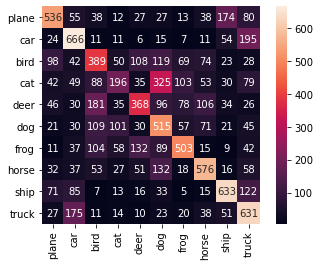

In [27]:
# Show the confusion matrix
pred = torch.squeeze(torch.cat(all_preds, 0))

target_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
sns.heatmap(confusion_matrix(test_dataset_targets, pred.cpu()),
             square=True, annot=True, fmt='d',
             xticklabels = target_names, yticklabels = target_names)

In [28]:
precision_recall_fscore_support(test_dataset_targets, pred.cpu(), average='macro')

(0.5001799110119769, 0.5013, 0.4941780593729689, None)

In [29]:
precision_recall_fscore_support(test_dataset_targets, pred.cpu(), average='micro')

(0.5013, 0.5013, 0.5013, None)

## Reference: CNN
***https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html***

In [30]:
# Train one Convoluational Neural Network
# as defined in the pytorch CIFAR10 tutorial.

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # 3-colors image channel, 6 output channels, 5x5 square kernel
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5) # transform shape
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [31]:
net = net.to(device)

In [32]:
# Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss() # Classification Cross-Entropy loss
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # SGD with momentum

In [33]:
# Train the network
t0 = time.time()

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad() # zero the gradient buffers

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step() # Does the update

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

t1 = time.time() - t0
total_training_time.append(t1)

print('Finished Training')

[1,  2000] loss: 2.249
[1,  4000] loss: 1.946
[1,  6000] loss: 1.725
[1,  8000] loss: 1.595
[1, 10000] loss: 1.547
[1, 12000] loss: 1.488
[2,  2000] loss: 1.404
[2,  4000] loss: 1.410
[2,  6000] loss: 1.373
[2,  8000] loss: 1.361
[2, 10000] loss: 1.312
[2, 12000] loss: 1.312
Finished Training


In [34]:
# Check accuracy after trainning one Convoluational Neural Network

all_preds = []

test_loader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

correct = 0
total = 0
t0 = time.time()

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.append(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

t1 = time.time() - t0
total_testing_time.append(t1)
test_accuracies.append(correct/total)

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


<AxesSubplot:>

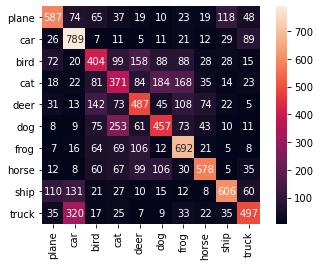

In [35]:
# Show the confusion matrix
pred = torch.squeeze(torch.cat(all_preds, 0))
sns.heatmap(confusion_matrix(test_dataset_targets, pred.cpu()),
             square=True, annot=True, fmt='d',
             xticklabels = target_names, yticklabels = target_names)

In [36]:
precision_recall_fscore_support(test_dataset_targets, pred.cpu(), average='macro')

(0.5525449538238643, 0.5468, 0.545202006755726, None)

In [37]:
precision_recall_fscore_support(test_dataset_targets, pred.cpu(), average='micro')

(0.5468, 0.5468, 0.5468, None)

# 4. Evaluation

In [38]:
test_accuracies, total_training_time, total_testing_time

([0.3624, 0.5013, 0.5468],
 [38338.6789598465, 797.7071495056152, 131.13579416275024],
 [2570.117486476898, 15.688930034637451, 8.296104431152344])

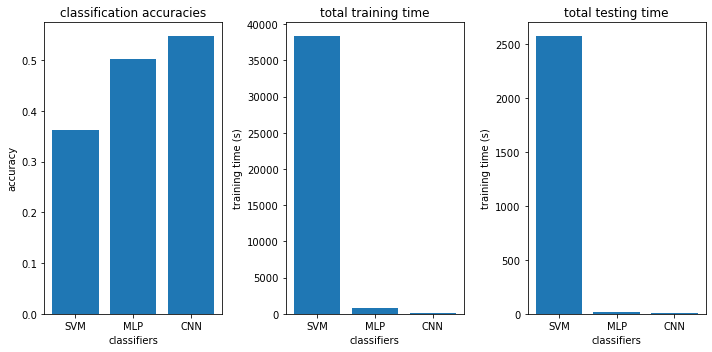

In [39]:
# Summarise the classification accuracy, total training time, and total test time

fig, axes = plt.subplots(nrows =1, ncols = 3, figsize=(10,5))

x_axis = ['SVM', 'MLP', 'CNN']

axes[0].bar(x_axis, test_accuracies)
axes[0].set_title("classification accuracies")
axes[0].set_xlabel("classifiers")
axes[0].set_ylabel("accuracy")

axes[1].bar(x_axis, total_training_time)
axes[1].set_title("total training time")
axes[1].set_xlabel("classifiers")
axes[1].set_ylabel("training time (s)")

axes[2].bar(x_axis, total_testing_time)
axes[2].set_title("total testing time")
axes[2].set_xlabel("classifiers")
axes[2].set_ylabel("training time (s)")

plt.tight_layout()
plt.show()

1. classification accuracies: CNN > MLP > SVM.
2. total training time: SVM on original features takes much more times than any other classifiers.
3. total testing time: SVM is the longest and MLP on original features is the second longest.

The differences between MLP and CNN are not significantly big but SVM returns much more for training and testing than other cases. This is because it computes 3*32*32 times through dataset. MLP is taking the second longest time to training.

1. As we already have seen in the Catdog dataset, moderate level size of pca components are working efficently to save the time. It also returns around 60% accuracy at the raw features plus gradually increase the accuracy depends on PCA components.
2. Normally when we run the classification task, it is telling us to consider which model is better and take complementary results. In this study, however, CNN gives the hightest classfication accuracy within the shortest testing time. Additionally, it is much better to run in GPU environment to take shorter runtime than CPU if it is available.
3. When we look over the confusion matrix for 3 classifiers, there are tables for the summarization of how much correct prediction. From the heatmap, we can find which classifier is working as well with vivid color tone during 10 classes tasks. And also we can check the big numbers and small numbers as indicators which class is classified at poor level.